## ICESat-2 ATL03 SlideRule Demo

Plot ATL03 data with different classifications for a region over the Grand Mesa, CO region 

- [ATL08 Land and Vegetation Height product](https://nsidc.org/data/atl08) photon classification
- Experimental YAPC (Yet Another Photon Classification) photon-density-based classification

### What is demonstrated

* The `icesat2.atl03sp` API is used to perform a SlideRule parallel subsetting request of the Grand Mesa region
* The `earthdata.cmr` API's is used to find specific ATL03 granules corresponding to the Grand Mesa region
* The `matplotlib` package is used to plot the ATL03 data subset by SlideRule

In [132]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import json

In [8]:
url = "slideruleearth.io"
icesat2.init(url, verbose=False)
asset = "icesat2"

### Retrieve ATL03 elevations with several classification options

For two region of interest (blackrock, utqiagvik)

In [236]:
region = "utqiagvik" # (blackrock, utqiagvik)

poly_fn = f"../../data/bbox_{region}.json"

pregion = gpd.read_file(poly_fn)
poly = sliderule.toregion(pregion)["poly"]

# Opening JSON file
f = open("../../data/icesat2_tracks.json")
data = json.load(f)

granule_id = data[region]['granule_id']
track = int(data[region]['beam'][2])
pair = 0 if data[region]['beam'][3]=="l" else 1

time_start = datetime.strptime(granule_id[6:14], "%Y%m%d").strftime("%Y-%m-%d")
time_end = (datetime.strptime(granule_id[6:14], "%Y%m%d") + timedelta(days=1)).strftime("%Y-%m-%d")
rgt = int(granule_id[21:25])

## Calculate ATL06-SR Elevations from ATL03 Photons using SlideRule

In [237]:
%%time

# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4
parms = {
    # processing parameters
    "srt": 0,
    "len": 20,
    "res": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": 0,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

# ICESat-2 data release
release = '006'
# region of interest

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', polygon=poly, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = poly
# gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)
gdf = icesat2.atl03sp(parms, asset=asset, resources=granules_list)


CPU times: user 4min 10s, sys: 4.78 s, total: 4min 15s
Wall time: 4min 20s


In [240]:
# Reduce dataframe for a single beam
def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = gdf.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    
    D3['x_atc'] = D3['segment_dist']+D3['distance']-np.min(D3['segment_dist'])

    # compute orthometric heights using the onboard geoid model (EGM08)
    D3['height_ortho'] = D3['height'] - D3['geoid']
    
    return D3

In [241]:
beam_type = 'strong'
project_srs = "EPSG:4326" #"EPSG:26912+EPSG:5703"
D3 = reduce_dataframe(gdf, RGT = rgt, track=track, pair = pair, beam='strong', crs=project_srs)

In [242]:
D3

,background_rate,rgt,segment_dist,segment_id,track,sc_orient,solar_elevation,cycle,atl08_class,yapc_score,...,landcover,height,ref_azimuth,ref_elev,geoid,pair,geometry,spot,x_atc,height_ortho
time,,,,,,,,,,,,,,,,,,,,,
2022-04-17 01:15:52.821399040,4.383076e+06,381,1.208686e+07,603405,1,0,23.647131,15,4,28,...,255,46.266670,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56400),1,-9.083188,47.466770
2022-04-17 01:15:52.821399040,4.383076e+06,381,1.208686e+07,603405,1,0,23.647131,15,4,0,...,255,-136.484421,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.589976,-135.284317
2022-04-17 01:15:52.821399040,4.383076e+06,381,1.208686e+07,603405,1,0,23.647131,15,4,0,...,255,-115.631218,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.646224,-114.431114
2022-04-17 01:15:52.821399040,4.383076e+06,381,1.208686e+07,603405,1,0,23.647131,15,4,19,...,255,3.893142,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.968743,5.093244
2022-04-17 01:15:52.821399040,4.383076e+06,381,1.208686e+07,603405,1,0,23.647131,15,1,138,...,255,-1.894285,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.953404,-0.694184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-17 01:15:57.832899072,6.045836e+06,381,1.212243e+07,605182,1,0,23.889448,15,1,178,...,255,5.113159,-0.409119,1.567681,-0.852745,0,POINT (-156.61926 71.24802),1,35553.003315,5.965905
2022-04-17 01:15:57.832899072,6.045836e+06,381,1.212243e+07,605182,1,0,23.889448,15,1,177,...,255,5.046567,-0.409119,1.567681,-0.852745,0,POINT (-156.61926 71.24802),1,35553.003708,5.899312
2022-04-17 01:15:57.832899072,6.045836e+06,381,1.212243e+07,605182,1,0,23.889448,15,1,172,...,255,4.833282,-0.409119,1.567681,-0.852745,0,POINT (-156.61926 71.24802),1,35553.004105,5.686028


### Inspect Coordinate Reference System

### Plot the ATL08 classifications

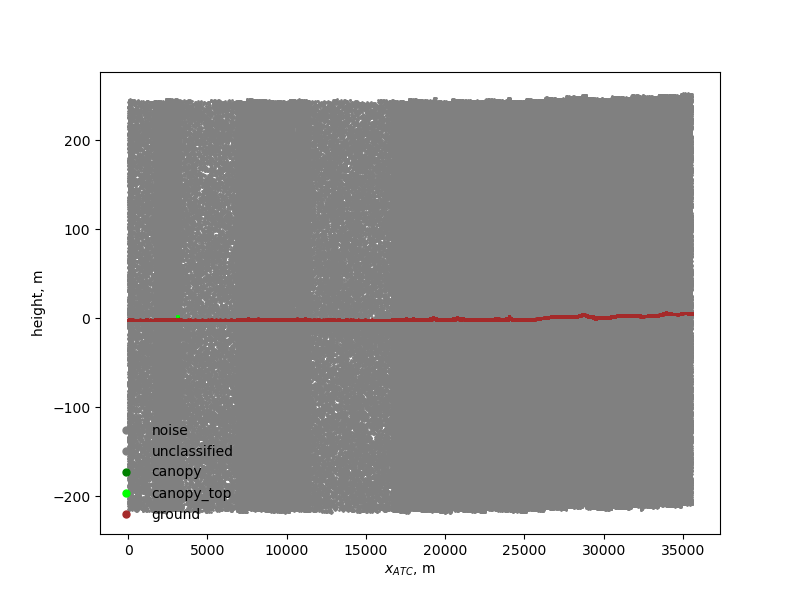

In [247]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']}
d0=np.min(D3['x_atc'])
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    plt.plot(D3['x_atc'][ii]-d0, D3['height'][ii],'o', 
         markersize=1, color=color_name[0], label=color_name[1])
hl=plt.legend(loc=3, frameon=False, markerscale=5)
# plt.gca().set_xlim([26000, 30000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

### Plot the YAPC classifications

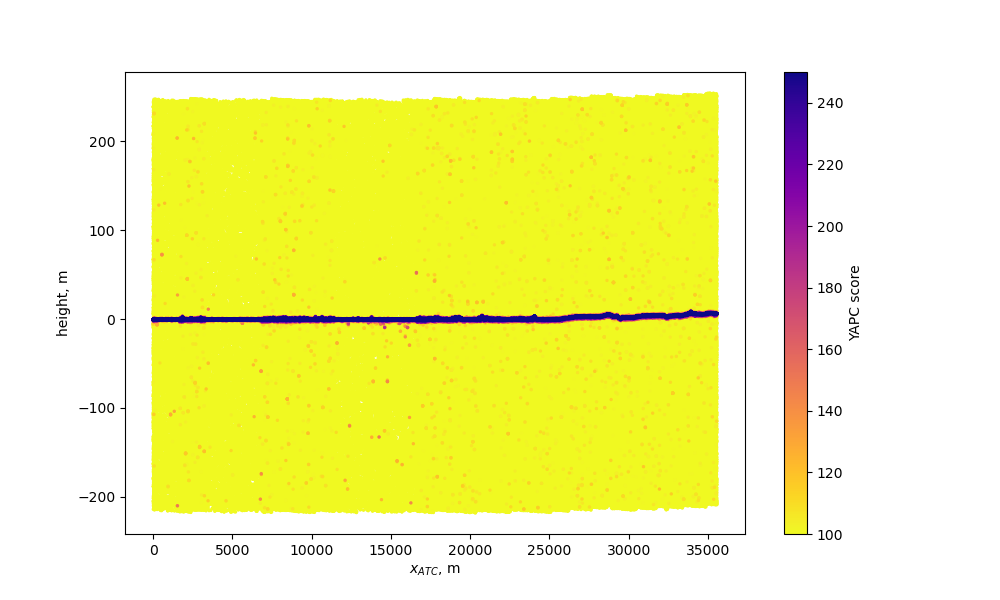

In [244]:
plt.figure(figsize=[10,6])

d0=np.min(D3['x_atc'])
ii=np.argsort(D3['yapc_score'])
plt.scatter(D3['x_atc'][ii] - d0,
    D3['height_ortho'][ii],2, c=D3['yapc_score'][ii],
    vmin=100, vmax=250,cmap='plasma_r')
plt.colorbar(label='YAPC score')
# plt.gca().set_xlim([0, 5000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

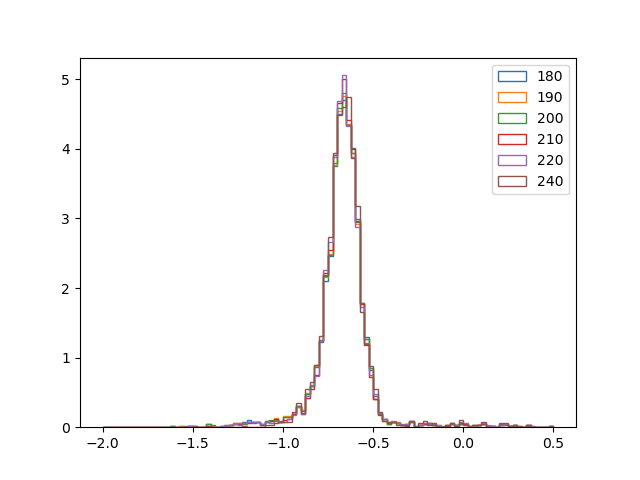

In [266]:
plt.figure()
df = D3[(D3['x_atc'] > 13000) & (D3['x_atc'] < 14000)]
hmean = np.mean(df['height_ortho'])
hstd = np.std(df['height_ortho'])/2
hrange = (hmean-hstd, hmean+hstd)
hrange = (np.quantile(df['height_ortho'], 0.02), np.quantile(df['height_ortho'], 0.98))
hrange = (-2, 0.5)

for yapc_threshold in [180, 190, 200, 210, 220, 240]: 
    signal = df['yapc_score'] > yapc_threshold
    plt.hist(df.loc[signal, 'height_ortho'].values, histtype = "step", label = yapc_threshold,
             range = hrange, bins = 100, density = True);
    
plt.legend()

In [71]:
# yapc_threshold = skimage.filters.threshold_otsu(df['yapc_score'])
# plt.hist(df['yapc_score'])
# plt.axvline(yapc_threshold)

yapc_threshold = 100

# Preprocess Data
First, let remove any noise / land photons from the data. Then, let's start to extract water surface and seafloor from the photon data. There are several approaches for this in the literature, but we'll focus on a generalizable, expandable method of histogramming the photon data at a specified resolution.

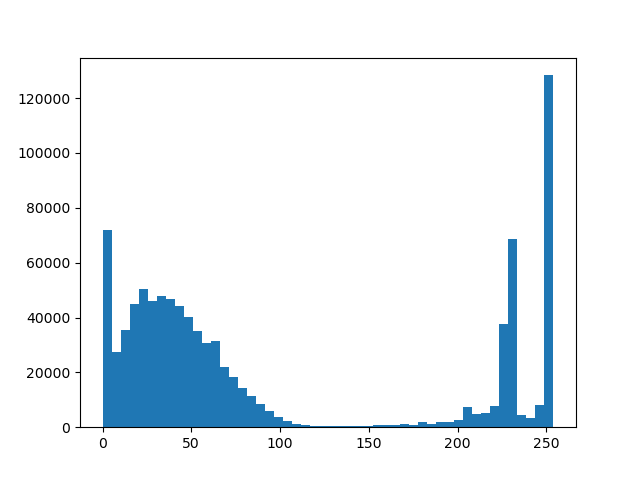

In [254]:
plt.figure()
plt.hist(D3['yapc_score'], bins = 50);